### 허프 변환
허프 변환은 점들을 파라미터 공간으로 옮겨서 투표함으로써 형태를 찾아내는 기법
| 단계                        | 설명                       |
| ------------------------- | ------------------------ |
| 1️ 엣지 맵 생성               | Canny 등으로 경계선만 추출        |
| 2️ 파라미터 공간 정의            | 직선: (ρ, θ), 원: (a, b, r) |
| 3️ 각 엣지 픽셀로부터 가능한 형태에 투표 | Accumulator array 사용     |
| 4️ 득표수가 높은 파라미터 쌍 찾기     | 직선/원 검출 결과 도출            |

### 직선 검출 (표준 허프 변환)
엣지 맵(예: Canny)에서 흰 점(엣지 픽셀)들을 대상으로
파라미터 공간(ρ, θ)에 투표(accumulator array)
투표 결과 가장 득표수가 많은 (ρ, θ) 쌍이 직선 후보

### 원 검출 (허프 서클 변환)
원은 파라미터가 (a, b, r): 중심 좌표 + 반지름.
각 엣지 픽셀에서 가능한 중심과 반지름에 투표. 
득표수가 높은 (a, b, r)이 실제 원으로 간주

In [9]:
import cv2 as cv 

img = cv.imread('apples.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# cv.HoughCircles(
#   입력영상, 
#   방법(고정값), 
#   dp: 누적기 해상도 비율, 
#   minDist: 원 중심 간 최소 거리, 
#   param1: 내부 Canny 경계선 임계값, 캐니 에지 알고리즘 T(high)
#   param2: 원 중심 누적 임계값 (작으면 원 많이, 크면 확실한 원만), 비최대 억제할 때 사용되는 입곗값
#   minRadius: 최소 반지름,
#   maxRadius: 최대 반지름
# )
apples = cv.HoughCircles(
    gray, 
    cv.HOUGH_GRADIENT, 
    dp=1, 
    minDist=200, 
    param1=150, 
    param2=20, 
    minRadius=50, 
    maxRadius=120
)

for i in apples[0]: 
    center = (int(i[0]), int(i[1]))  # 원 중심 좌표
    radius = int(i[2])               # 원 반지름
    cv.circle(img, center, radius, (255, 0, 0), 2)  # 파란 원 그리기

cv.imshow('Apple detection', img)

cv.waitKey()
cv.destroyAllWindows()


| 파라미터     | 이유                                           |
| ----------- | -------------------------------------------- |
| `dp`        | 기본값으로 시작: 원본 해상도 그대로 사용                      |
| `minDist`   | 사과가 서로 붙어 있으면 겹쳐 검출될 수 있으므로 적당한 거리 설정        |
| `param1`    | 내부 Canny 엣지 강도        |
| `param2`    | 원 중심 검출 임계값: 작으면 더 많은 원을 잡지만 노이즈도 증가 |
| `minRadius` | 이미지 상에서 사과의 최소 반지름 추정 (픽셀 단위)                |
| `maxRadius` | 이미지 상에서 사과의 최대 반지름 추정                        |

# RANSAC (RANdom SAmple Consensus)

## 개념
- 노이즈와 이상치가 많은 데이터에서 신뢰성 있는 모델(직선, 평면, 변환행렬 등)을 찾는 알고리즘.
- 랜덤 샘플 → 모델 추정 → 얼마나 많은 데이터가 모델에 일치하는지 확인 → 가장 많은 합의를 얻은 모델 선택.

---

## 왜 필요할까?
- 현실 데이터(점군, 매칭)는 이상치가 많음.
- 최소자승법은 이상치에 매우 민감.
- RANSAC은 이상치를 무시하고 inlier만으로 모델을 최적화.

---

## 동작 흐름
1. **랜덤 샘플 선택**: 모델에 필요한 최소 샘플 뽑기
2. **모델 추정**: 샘플로 모델 파라미터 계산
3. **일치 점 확인**: 데이터 전체에 대해 inlier/outlier 판단
4. **반복**: 최적의 합의 모델이 나올 때까지 반복
5. **최종 모델 선택**: 가장 많은 inlier가 모인 모델 사용

---

## 장점 vs 단점
| 장점 | 단점 |
|------|------|
| 이상치에 강함 | 반복 횟수 많으면 속도 느림 |
| 직관적, 다양한 모델에 적용 가능 | 임계값, 반복 횟수 튜닝 필요 |

---

## 대표 활용
- 특징점 매칭 필터링
- 호모그래피(동차 변환) 추정
- 직선/평면 피팅
- SLAM (위치추정 & 지도작성)

---

## 핵심 한 줄
> RANSAC = 랜덤 샘플로 이상치에 강한 모델을 찾는 합의 기반 알고리즘

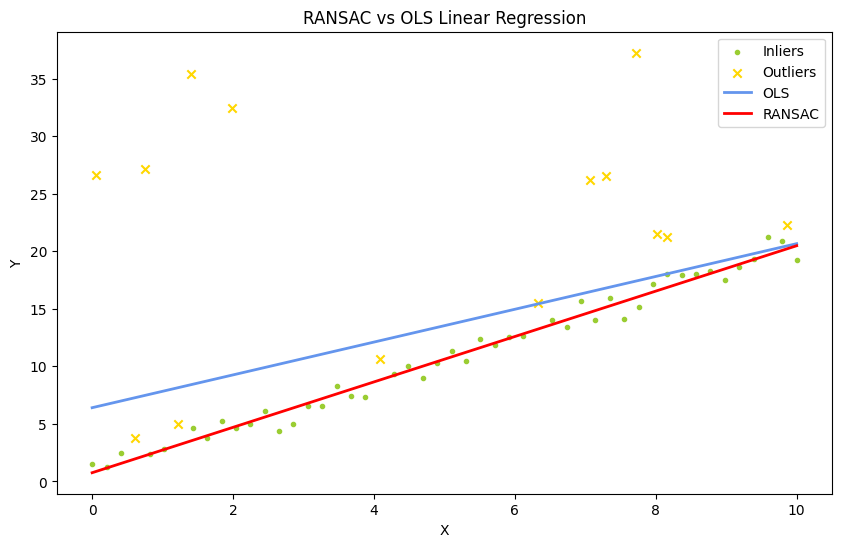

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression

# 1) 샘플 데이터 만들기
np.random.seed(42)

# Inlier 데이터 (직선 y = 2x + 1)
X = np.linspace(0, 10, 50)
Y = 2 * X + 1 + np.random.normal(scale=1.0, size=X.shape)

# Outlier 추가
n_outliers = 10
X_outliers = np.random.uniform(0, 10, n_outliers)
Y_outliers = np.random.uniform(20, 40, n_outliers)

# X, Y 데이터 합치기
X_all = np.concatenate([X, X_outliers])
Y_all = np.concatenate([Y, Y_outliers])

X_all = X_all.reshape(-1, 1)  # sklearn은 2D 형태

# 2) 선형 회귀 (OLS)
ols = LinearRegression()
ols.fit(X_all, Y_all)
Y_ols = ols.predict(X_all)

# 3) RANSAC 회귀
ransac = RANSACRegressor(estimator=LinearRegression(), 
                         min_samples=2, residual_threshold=2.0, random_state=42)
ransac.fit(X_all, Y_all)
Y_ransac = ransac.predict(X_all)

# Inlier mask 확인
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# 4) 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_all[inlier_mask], Y_all[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
plt.scatter(X_all[outlier_mask], Y_all[outlier_mask], color='gold', marker='x', label='Outliers')

line_X = np.linspace(0, 10, 100).reshape(-1, 1)
plt.plot(line_X, ols.predict(line_X), color='cornflowerblue', linewidth=2, label='OLS')
plt.plot(line_X, ransac.predict(line_X), color='red', linewidth=2, label='RANSAC')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('RANSAC vs OLS Linear Regression')
plt.show()


In [2]:
import sys
print(sys.executable)

c:\Users\asia\.conda\envs\py310_\python.exe
